# Imports

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

import pcshrink

# Data prep

Read in the human origins west eurasian data

In [29]:
%%time
data = pcshrink.UnpackedAncestryMap("/project/jnovembre/jhmarcus/ancient-sardinia/data/ref_genotypes/7-11-2018/lazaridis_2014/data_fil")

CPU times: user 7.8 s, sys: 2.09 s, total: 9.89 s
Wall time: 3.58 s


In [30]:
Y = data.Y
p, n = Y.shape
print(p, n)

594924 777


In [31]:
norm = pcshrink.Normalizer(Y, .02, "patterson")

In [32]:
Z = norm.Y

# PCA

In [114]:
def svd(Y, k, flip=True):
    
    U, S, VT = svds(Y, k)

    # singular values
    S = np.diag(S[::-1])

    if flip:
        # left and right eigenvectors
        U, VT = svd_flip(U[:, ::-1], VT[::-1])

    V = VT.T
    
    return(U, S, V)

In [249]:
%%time
k = 5
n_snp, n_samp = Z.shape
U, S, V = svd(Z, k, flip=True)
F = U @ S
F = F / np.linalg.norm(F, axis=0, ord=2)
L = (F.T @ Z).T

CPU times: user 24.3 s, sys: 574 ms, total: 24.8 s
Wall time: 890 ms


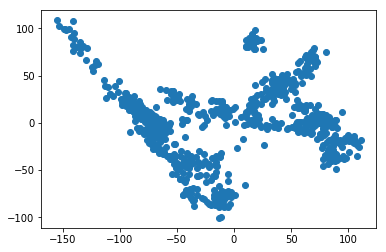

In [250]:
plt.scatter(L[:, 0], L[:, 1])

In [254]:
i = 192
a = -Z[:, i].reshape(n_snp, 1)
b = np.zeros(n_samp).reshape(n_samp, 1)
b[-1] = 1

v_last = V[-1, :]
v_i = V[i, :]
V[-1, :] = v_i
V[i, :] = v_last

In [255]:
# just making sure the last column is the person I deleted
Z_approx = U @ S @ V.T
print(np.corrcoef(Z_approx[:, -1], -a.reshape(-1))[0, 1])
print(np.corrcoef(Z_approx[:, -1], Z[:, 100].reshape(-1))[0, 1])


0.19635937469296166
-0.02261010487643919


In [256]:
m = U.T @ a
p = a - (U @ m)
R_a = np.sqrt(p.T @ p)
P = (1. / R_a) * p

n = V.T @ b
q = b - (V @ n)
R_b = np.sqrt(q.T @ q)
Q = (1. / R_b) * q

In [257]:
K_0 = np.zeros((S.shape[0] + 1, S.shape[0] + 1))
K_0[:-1, :-1] = S
K.shape
K_1 = np.append(m, R_a).reshape(-1, 1) @ np.append(n, R_b).reshape(1, -1)
K = K_0 + K_1

#K = np.array(np.matrix(np.diag(list(np.diag(S)) + [0.0])))
#I = np.eye(K.shape[0])
#e = np.append((S @ n), 0.0).reshape(-1, 1)
#fT = np.append(n, np.sqrt(1. - (n.T @ n))).reshape(1, -1)
#K = K @ (I - (e @ fT))

In [258]:
tUp, tSp, tVpT = np.linalg.svd(K, full_matrices=False)
#tUp, tVpT = svd_flip(tUp, tVpT)

tUp = np.array(tUp[:, :k])
tVp = np.array(tVpT.T[:, :k])
Sp = np.array(np.diag(tSp[:k]))
Up = np.array(np.bmat('U P') * tUp)
Vp = np.array(np.bmat('V Q') * tVp)
#Up, VpT = svd_flip(Up, Vp.T)

Force orthongality

In [259]:
UQ, UR = np.linalg.qr(Up)
VQ, VR = np.linalg.qr(Vp)
tUp, tSp, tVpT = np.linalg.svd(UR @ Sp @ VR.T, full_matrices=False)
Up = UQ @ tUp
Vp = VQ @ tVpT.T
Up, VpT = svd_flip(Up, Vp.T)

Reproject the heldout person

In [260]:
Fp = Up @ Sp
Fp = Fp / np.linalg.norm(Fp, axis=0, ord=2)
Fp.shape

(426765, 5)

In [261]:
%%time 
Lp = (Fp.T @ Z[:, i]).T
Lp.shape

CPU times: user 160 ms, sys: 134 ms, total: 294 ms
Wall time: 205 ms


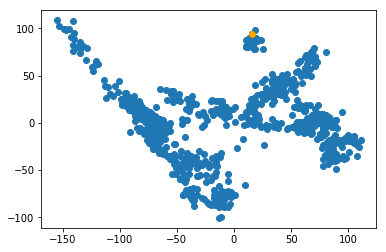

In [262]:
plt.scatter(L[:,0], L[:,1])
plt.scatter(L[i, 0], L[i, 1], color="black")
plt.scatter(Lp[0], Lp[1], color="orange")

In [263]:
for r in range(k):
    print(np.corrcoef(Fp[:, r], F[:, r])[0, 1])

0.999999707845563
0.9999987217774592
0.9999999675778548
0.9999962989965814
0.9999973350245375


Run the svd actually holding out that point ... 

In [274]:
j = 192
idx = np.zeros(n_samp, dtype="bool")
idx[j] = 1 
Zs = Z[:, ~idx]
Us, Ss, Vs = svd(Zs, k, flip=True)
Fs = Us @ Ss
Fs = Fs / np.linalg.norm(Fs, axis=0, ord=2)
Ls = (Fs.T @ Z[:, j]).T

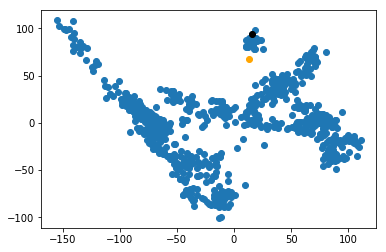

In [273]:
plt.scatter(L[:,0], L[:,1])
plt.scatter(L[j, 0], L[j, 1], color="black")
plt.scatter(Ls[0], Ls[1], color="orange")